In [13]:
import numpy as np
import pandas as pd
import random

import os 
import ast
import glob
from scipy.ndimage import zoom
from tqdm import tqdm

#lire les images
import pydicom
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import masking

np.random.seed(42) 

In [14]:
df = pd.read_csv('/kaggle/input/df-cleaned/df(1).csv')
df_loc = pd.read_csv('/kaggle/input/rsna-intracranial-aneurysm-detection/train_localizers.csv')
df_train = pd.read_csv('/kaggle/input/rsna-intracranial-aneurysm-detection/train.csv')

In [15]:
df1=np.load("/kaggle/input/cubes-positifs/cubes_MRI_T1post.npy")
df2=np.load("/kaggle/input/cubes-positifs/cubes_MRI_T2.npy")
df3a=np.load("/kaggle/input/cubes-positifs/cubes_MRA_1.npy")
df3b=np.load("/kaggle/input/cubes-positifs/cubes_MRA_2.npy")
df3=np.concatenate([df3a,df3b],axis=0)
df4a=np.load("/kaggle/input/cubes-positifs/cubes_CTA_1.npy")
df4b=np.load("/kaggle/input/cubes-positifs/cubes_CTA_2.npy")
df4c=np.load("/kaggle/input/cubes-positifs/cubes_CTA_3.npy")
df4d=np.load("/kaggle/input/cubes-positifs/cubes_CTA_4.npy")
df4=np.concatenate([df4a,df4b,df4c,df4d],axis=0)

In [16]:
print("Nombre d'éléments dans df1 :",len(df1))
print("Nombre d'éléments dans df2 :",len(df2))
print("Nombre d'éléments dans df3 :",len(df3))
print("Nombre d'éléments dans df4 :",len(df4))

Nombre d'éléments dans df1 : 90
Nombre d'éléments dans df2 : 119
Nombre d'éléments dans df3 : 544
Nombre d'éléments dans df4 : 780


In [17]:
def ajouter_Modality(df_main,df_info):
    df_merged = df_main.merge(
        df_info[['SeriesInstanceUID', 'Modality']],
        on='SeriesInstanceUID',
        how='left'  # conserve toutes les lignes de df_main
    )
    return df_merged

df_loc=ajouter_Modality(df_loc,df_train)

# **Fonctions utiles**

## **Lire une image**

In [ ]:
def lire_image(i):

    # chemin vers le fichier DICOM
    series_path='/kaggle/input/rsna-intracranial-aneurysm-detection/series'
    dicom_path = os.path.join(series_path,
                              f"{df_loc['SeriesInstanceUID'][i]}/{df_loc['SOPInstanceUID'][i]}.dcm"
                             )

    # lire le fichier DICOM
    ds = pydicom.dcmread(dicom_path)

    # accéder aux pixels
    image = ds.pixel_array



    # récupérer les coordonnées
    coords_str = df_loc['coordinates'][i]   # par exemple
    coords = ast.literal_eval(coords_str)
    x, y = coords['x'], coords['y']

    # créer les subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # image sans point
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title("Sans point")
    axes[0].axis('on')
    
    # image avec point
    axes[1].imshow(image, cmap='gray')
    axes[1].scatter(x, y, c='red', s=50, marker='x')
    axes[1].set_title("Avec point")
    axes[1].axis('on')

    # titre global
    fig.suptitle(f"Image {i} , Localisation : {df_loc['location'][i]}", fontsize=16)
    plt.show()

In [19]:
def show_middle_slices(volume):
    # volume shape : (X, Y, Z)
    mid_x = volume.shape[0] // 2
    mid_y = volume.shape[1] // 2
    mid_z = volume.shape[2] // 2

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Coupe axiale (XY plane à profondeur z)
    axes[0].imshow(volume[:, :, mid_z].T, cmap='gray')  # transpose pour que X horizontal, Y vertical
    axes[0].set_title(f'Axiale (z={mid_z})')
    axes[0].axis('on')

    # Coupe coronale (XZ plane à coordonnée y)
    axes[1].imshow(volume[:, mid_y, :].T, cmap='gray')  # transpose pour X horizontal, Z vertical
    axes[1].set_title(f'Coronale (y={mid_y})')
    axes[1].axis('on')

    # Coupe sagittale (YZ plane à coordonnée x)
    axes[2].imshow(volume[mid_x, :, :].T, cmap='gray')  # transpose pour Y horizontal, Z vertical
    axes[2].set_title(f'Sagittale (x={mid_x})')
    axes[2].axis('on')

    plt.tight_layout()
    plt.show()

In [20]:
def show_slice_with_point(volume, coord, plane="axial"):

    """
    Affiche une coupe du volume 3D avec un point marqué.
    
    volume : np.ndarray 3D
    coord  : (x,y,z) coordonnées voxel
    plane  : "axial", "sagittal", "coronal"
    """
    x, y, z = coord.astype(int)  # indices voxel entiers

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    if plane == "axial":  # plan XY à profondeur z
        img = volume[:, :, z]
        ax[0].imshow(img, cmap="gray")
        ax[1].imshow(img, cmap="gray")
        ax[1].scatter(x, y, c="r", s=40, marker="x")

        title = f"Coupe axiale z={z}"

    elif plane == "sagittal":  # plan YZ à abscisse x
        img = volume[x, :, :].T  # transpose pour orienter correctement
        ax[0].imshow(img, cmap="gray")
        ax[1].imshow(img, cmap="gray")
        ax[1].scatter(z, y, c="r", s=40, marker="x")

        title = f"Coupe sagittale x={x}"


    elif plane == "coronal":  # plan XZ à ordonnée y
        img = volume[:, y, :].T
        ax[0].imshow(img, cmap="gray")
        ax[1].imshow(img, cmap="gray")
        ax[1].scatter(z, x, c="r", s=40, marker="x")

        title = f"Coupe coronale y={y}"

    else:
        raise ValueError("plane doit être 'axial', 'sagittal' ou 'coronal'")

    ax[0].set_title(title)
    ax[1].set_title(title + " + point")

    for a in ax:
        a.axis("on")

    plt.tight_layout()
    plt.show()

## **Orientation et PixelSpacing**

In [21]:
def orientation_image(i):
    series_path='/kaggle/input/rsna-intracranial-aneurysm-detection/series'
    dicom_path = os.path.join(series_path,
                                  f"{df_loc['SeriesInstanceUID'][i]}/{df_loc['SOPInstanceUID'][i]}.dcm"

                                 )
    
    # lire le fichier DICOM
    ds = pydicom.dcmread(dicom_path)
    iop=ds.ImageOrientationPatient
    
    row = np.array(iop[0:3], dtype=float)
    col = np.array(iop[3:6], dtype=float)
    normal = np.cross(row, col)

    axis = np.argmax(np.abs(normal))  # axe dominant

    if axis == 0:
        return "Sagittal"
    elif axis == 1:
        return "Coronal"
    elif axis == 2:
        return "Axial"
    else:
        return "Inconnu"

In [22]:
def pixel_spacing_image(i):
    series_path='/kaggle/input/rsna-intracranial-aneurysm-detection/series'
    dicom_path = os.path.join(series_path,
                                  f"{df_loc['SeriesInstanceUID'][i]}/{df_loc['SOPInstanceUID'][i]}.dcm"
                                 )
    
    # lire le fichier DICOM
    ds = pydicom.dcmread(dicom_path)
    pixel_spacing = ds.PixelSpacing  # [dy, dx] en mm

    # épaisseur de coupe
    slice_thickness = getattr(ds, "SliceThickness", None)
    
    # espacement entre coupes (si dispo)
    spacing_between_slices = getattr(ds, "SpacingBetweenSlices", None)
    
    print("Pixel Spacing (mm):", pixel_spacing)
    print("Slice Thickness (mm):", slice_thickness)
    print("Spacing Between Slices (mm):", spacing_between_slices)
    return pixel_spacing,slice_thickness,spacing_between_slices## **Preprocessing**

## **Preprocessing**

In [62]:
def dicom_to_numpy(patient_path):
    
    dicom_files = sorted(glob.glob(patient_path+'/*.dcm'))
    slices = [pydicom.dcmread(f) for f in dicom_files]

    #tri des slices par instance number
    slices.sort(key=lambda s: int(s.InstanceNumber))
    
    # On empile les pixel_array en un volume 3D NumPy (X,Y,Z)
    target_shape = slices[0].pixel_array.shape
    slices = [s for s in slices if s.pixel_array.shape == target_shape]
    volume = np.stack([s.pixel_array for s in slices], axis=-1)

    # Récupération du spacing réel
    pixel_spacing = slices[0].PixelSpacing
    dx, dy = pixel_spacing
    dz = getattr(slices[0], 'SliceThickness', 1.0)  # fallback si manquant
    
    return volume, (dx,dy,dz)

def resample(volume, spacing, target_spacing=(0.4, 0.4, 0.4)):
    zoom_factors = [s / t for s, t in zip(spacing, target_spacing)]
    new_volume = zoom(volume, zoom_factors, order=1)
    return new_volume

def crop(volume):
 
    # On crée un masque des voxels non nuls
    mask = volume > 10
    if not mask.any():
        return volume  # rien à couper
    
    # On récupère les indices min/max pour chaque dimension
    x_min, x_max = mask.any(axis=(1,2)).nonzero()[0][[0, -1]] #axe_x
    y_min, y_max = mask.any(axis=(0,2)).nonzero()[0][[0, -1]] #axe_y
    z_min, z_max = mask.any(axis=(0,1)).nonzero()[0][[0, -1]] #axe_z
    
    # Crop
    cropped = volume[x_min:x_max+1, y_min:y_max+1, z_min:z_max+1]
    return cropped, (x_min,y_min,z_min)

def resize(volume):
    """
    Redimensionne le volume 3D à la taille target_shape par interpolation linéaire.
    """
    target_shape=(128,128,64)
    factors = [t/s for t, s in zip(target_shape, volume.shape)]
    resized_volume = zoom(volume, factors, order=1)
    return resized_volume

# Normaliser un tableau numpy 3D
def normalization(volume):
    """
    Normalise un volume entre 0 et 1 (par patient).

    """
    v_min, v_max = volume.min(), volume.max()
    if v_max > v_min:  # éviter la division par zéro
        volume = (volume - v_min) / (v_max - v_min)
    else:
        volume = np.zeros_like(volume)
    return volume

def preprocessing(patient_path):
    
    volume,spacing = dicom_to_numpy(patient_path)
    volume = resample(volume, spacing)
    volume = crop(volume)
    #volume = resize(volume)
    volume = normalization(volume)

    return volume

## **Preprocess coordonnées**

In [24]:
def coordonnee_z(patient_path,InstanceNumber=163):
    
    dicom_files = sorted(glob.glob(patient_path+'/*.dcm'))
    slices = [pydicom.dcmread(f) for f in dicom_files]
    #tri des slices par instance number
    slices.sort(key=lambda s: int(s.InstanceNumber))

    # Trouver l’indice z dans le volume
    z_index = [i for i, s in enumerate(slices) if int(s.InstanceNumber) == InstanceNumber][0]

    return z_index

In [25]:
def resample_coordonnees(spacing, x, y, z):
    voxel = np.array([x, y, z])
    dx, dy, dz = spacing
    new_voxel = voxel * np.array([dx/0.4, dy/0.4, dz/0.4])
    return new_voxel


def crop_coordonnees(resample_volume,x,y,z):

    voxel=np.array([x,y,z])
    mask = resample_volume > 10
    if not mask.any():
        return resample_volume, np.array([0,0,0])
    
    x_min, x_max = mask.any(axis=(1,2)).nonzero()[0][[0, -1]]
    y_min, y_max = mask.any(axis=(0,2)).nonzero()[0][[0, -1]]
    z_min, z_max = mask.any(axis=(0,1)).nonzero()[0][[0, -1]]
    
    crop_coords = np.array([y_min, x_min,z_min])
    new_voxel = voxel - crop_coords
    return new_voxel

def preprocessing_coord(x,y,z,spacing,volume):
    "Coordonnées : (x,y,z)"

    x,y,z=resample_coordonnees(spacing, x, y, z)
    resample_volume=resample(volume,spacing)
    new_voxel=crop_coordonnees(resample_volume,x,y,z)

    return new_voxel 

## **Decoupe d'un patch**

In [26]:
def crop_cube(volume, center, size=48):
    """
    Extrait un cube 3D de taille (size,size,size) centré sur 'center' dans volume.

    - volume : ndarray 3D (X, Y, Z)
    - center : tuple ou array (x, y, z)
    - size   : taille du cube à extraire
    """
    half = size // 2
    x, y, z = np.round(center).astype(int)

    # Calcul des bornes
    x_min, x_max = x - half, x + half
    y_min, y_max = y - half, y + half
    z_min, z_max = z - half, z + half

    # S'assurer que les bornes restent dans le volume
    x_min = max(0, x_min)
    y_min = max(0, y_min)
    z_min = max(0, z_min)
    x_max = min(volume.shape[0], x_max)
    y_max = min(volume.shape[1], y_max)
    z_max = min(volume.shape[2], z_max)

    # Extraire le cube
    cube = volume[x_min:x_max, y_min:y_max, z_min:z_max]

    return cube

In [27]:
def from_patient_path_to_cube(patient_path):
    volume,spacing=dicom_to_numpy(patient_path)
    

    numero_patient=os.path.basename(patient_path)
    numero_coupe=df_loc[df_loc['SeriesInstanceUID']==numero_patient]['SOPInstanceUID'].iloc[0]
    exemple_path = os.path.join(series_path,
                                  f"{numero_patient}/{numero_coupe}.dcm")
    #print('Récupération des coordonnées du voxel...')
    ds = pydicom.dcmread(exemple_path)
    
    InstanceNumber=ds.InstanceNumber
    
    z=coordonnee_z(patient_path,InstanceNumber)

    coord_str = df_loc[df_loc['SOPInstanceUID'] == numero_coupe]['coordinates'].iloc[0]
    coord_dict = ast.literal_eval(coord_str)
    x = coord_dict['x']
    y = coord_dict['y']

    voxel=np.array([x,y,z])
    #print('Récupération des coordonnées du voxel terminée !')

    new_volume=preprocessing(patient_path)
    new_voxel=preprocessing_coord(x,y,z,spacing,volume)
    #print('Création du cube...')
    cube=crop_cube(new_volume,new_voxel,size=48)

    return cube

In [28]:
def dataset_cubes(df):
    cubes = []
    for index, row in tqdm(df.iterrows(), total=len(df)):
        #lien du patient (série)
        patient_path=os.path.join(series_path,row['SeriesInstanceUID'])
        cube=from_patient_path_to_cube(patient_path)
        cubes.append(cube)

    return cubes

## **Découpe d'un patch négatif**

In [29]:
def get_random_center(volume, max_shift_ratio=0.2): #un 20%
    """
    Calcule un centre aléatoire proche du centre du volume.
    
    volume : ndarray 3D
    max_shift_ratio : fraction de la dimension (ex: 0.1 = ±10%)
    """
    z, y, x = volume.shape
    center = np.array([z // 2, y // 2, x // 2])

    # bornes de décalage (ex: 10% de chaque dimension)
    max_shift = np.array([z, y, x]) * max_shift_ratio

    # tirage uniforme entier dans l'intervalle [-max_shift, +max_shift]
    shift = np.array([
        np.random.randint(-int(ms), int(ms) + 1)
        for ms in max_shift
    ])

    random_center = center + shift

    # sécurité : rester dans le volume
    random_center = np.clip(random_center, [0,0,0], [z-1, y-1, x-1])

    return random_center

In [30]:
def get_non_overlapping_cubes(volume, cube_size=48):

    """
    Découpe un volume en cubes non chevauchants de taille fixe.
    
    volume : ndarray 3D
    cube_size : taille du cube (entier)
    
    Retourne une liste de tuples ((x, y, z), cube)
    où (x, y, z) = coordonnées de départ du cube
    """
    z_dim, y_dim, x_dim = volume.shape
    cubes = []

    # parcours par pas de cube_size
    for zi in range(0, z_dim - cube_size + 1, cube_size):
        for yi in range(0, y_dim - cube_size + 1, cube_size):
            for xi in range(0, x_dim - cube_size + 1, cube_size):
                cube = volume[zi:zi+cube_size, yi:yi+cube_size, xi:xi+cube_size]
                cubes.append(cube)

    return cubes

In [31]:
def from_patient_path_to_neg_cube(patient_path):
    volume=preprocessing(patient_path)
    cube=get_non_overlapping_cubes(volume, cube_size=48)
    
    return cube

In [32]:
def dataset_cubes_neg(df):
    cubes = []
    for index, row in tqdm(df.iterrows(), total=len(df)):
        #lien du patient (série)
        patient_path=os.path.join(series_path,row['SeriesInstanceUID'])
        cube=from_patient_path_to_neg_cube(patient_path)
        n_select = min(20, len(cube))
        selected_cubes = random.sample(cube, n_select)
        cubes.extend(selected_cubes)

    return cubes

# **Exemples négatifs**

In [33]:
df_train_neg=df_train[df_train['Aneurysm Present']==0]
df_train_neg.head(2)

,SeriesInstanceUID,PatientAge,PatientSex,Modality,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present
0,1.2.826.0.1.3680043.8.498.10004044428023505108...,64,Female,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.8.498.10004684224894397679...,76,Female,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
common_values = df_train_neg["SeriesInstanceUID"][df_train_neg["SeriesInstanceUID"].isin(df_loc["SeriesInstanceUID"])]

In [35]:
df_train_neg['Modality'].value_counts()

Modality
CTA           834
MRI T2        725
MRA           697
MRI T1post    228
Name: count, dtype: int64

# **Travail avec un exemple**

df[935]
df_train_neg[0]
df_train[0]

* NumSlices : 188
* image.shape : 512 (y) x512 (x)
* volume.shape : (179, 179, 94) # (z,y,x)
* Modality : MRA

In [36]:
df_train_neg.head(1)

,SeriesInstanceUID,PatientAge,PatientSex,Modality,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present
0,1.2.826.0.1.3680043.8.498.10004044428023505108...,64,Female,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [37]:
df_train[df_train['SeriesInstanceUID']==df_train_neg['SeriesInstanceUID'][0]]

,SeriesInstanceUID,PatientAge,PatientSex,Modality,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present
0,1.2.826.0.1.3680043.8.498.10004044428023505108...,64,Female,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [38]:
df[df['SeriesInstanceUID']==df_train_neg['SeriesInstanceUID'][0]]

,SeriesInstanceUID,PatientPath,NumSlices,Aneurysm Present
935,1.2.826.0.1.3680043.8.498.10004044428023505108...,/kaggle/input/rsna-intracranial-aneurysm-detec...,188,0


In [58]:
series_path='/kaggle/input/rsna-intracranial-aneurysm-detection/series'
#lien du patient (série)
patient_path=os.path.join(series_path,
                                  f"{df_train_neg['SeriesInstanceUID'][6]}")
#lien d'une coupe
# Lister les fichiers dans ce dossier
all_files = os.listdir(patient_path)
# Filtrer éventuellement pour ne garder que les fichiers DICOM (.dcm)
dicom_files = [f for f in all_files if f.endswith(".dcm")]
# Prendre le premier fichier pour exemple
exemple_path = os.path.join(patient_path, dicom_files[0])

ds = pydicom.dcmread(exemple_path)

# accéder aux pixels
image = ds.pixel_array
image.shape

(512, 512)

In [28]:
iop=ds.ImageOrientationPatient
row = np.array(iop[0:3], dtype=float)
col = np.array(iop[3:6], dtype=float)
normal = np.cross(row, col)

axis = np.argmax(np.abs(normal))  # axe dominant

if axis == 0: 
  print("Sagittal")
elif axis == 1:
    print("Coronal")
elif axis == 2:
    print("Axial")
else:
    print("Inconnu")

Axial


(512, 512, 239)


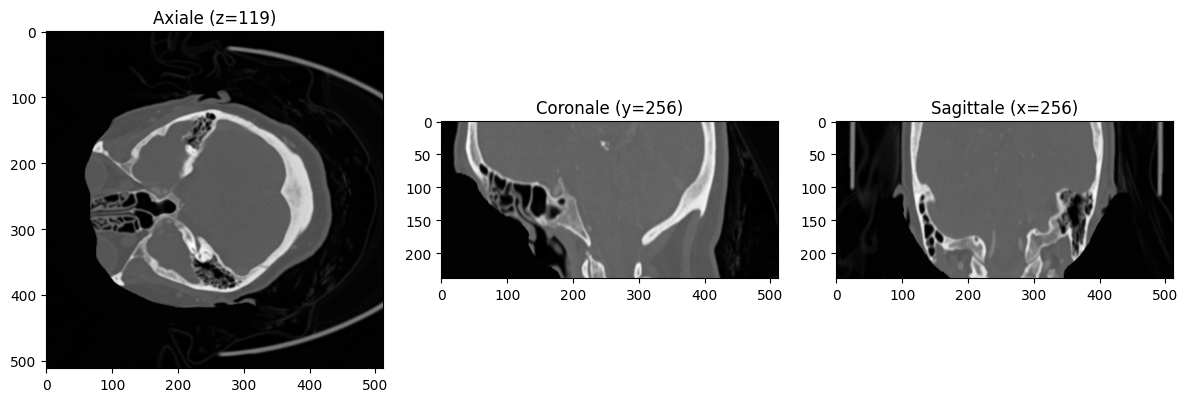

In [59]:
volume,spacing=dicom_to_numpy(patient_path)
print(volume.shape)
show_middle_slices(volume)

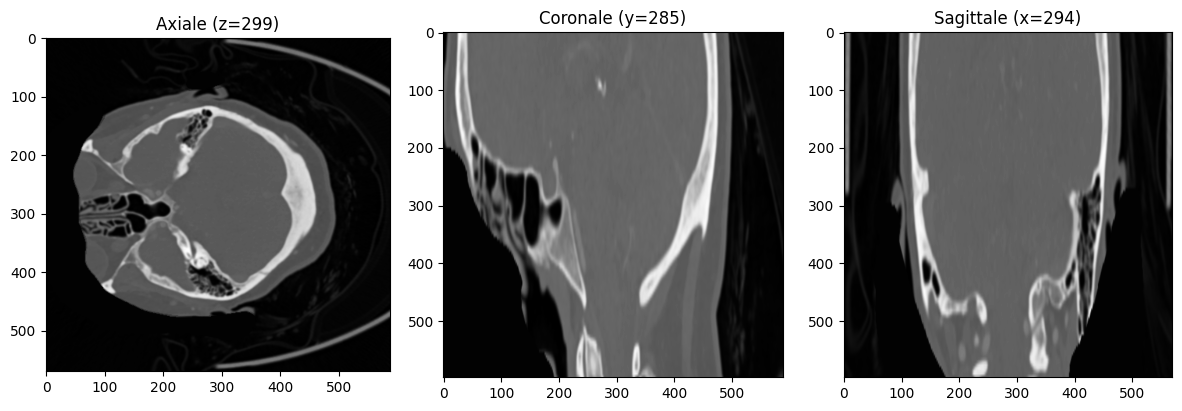

In [60]:
volume=preprocessing(patient_path)
show_middle_slices(volume)

In [61]:
volume.shape

(588, 570, 598)

In [31]:
bright_voxels = np.argwhere(volume == volume.max())

In [32]:
bright_voxels[0]

array([85, 89, 50])

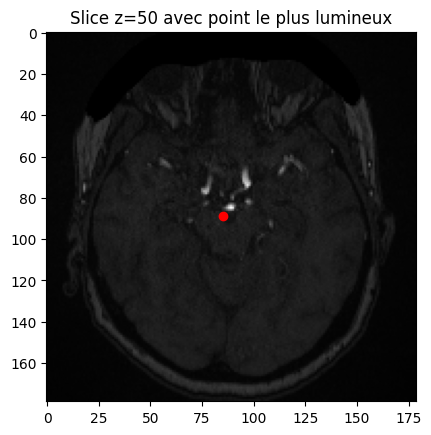

In [33]:
x,y,z= 85, 89, 50  # ton point max

# slice axiale (XY plane) à la profondeur z
plt.imshow(volume[:, :, z], cmap='gray')
plt.scatter(x, y, color='red')  # le point choisi
plt.title(f"Slice z={z} avec point le plus lumineux")
plt.show()

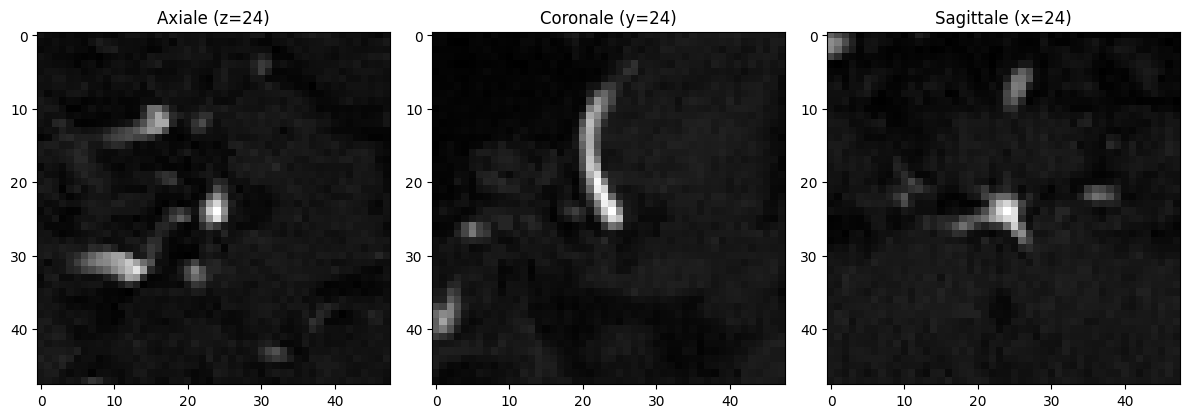

In [34]:
cube=crop_cube(volume, np.array([x,y,z]), size=48)
show_middle_slices(cube)

# **Autre exemple**

df[122]
df_train_neg[6]
df_train[6]

* NumSlices : 239
* image.shape : 512 (y) x512 (x)
* volume.shape : (234, 228, 239) #(z,y,x)
* Modality : CTA

In [35]:
df_train_neg[df_train_neg['Modality']=='CTA'].head(2)

,SeriesInstanceUID,PatientAge,PatientSex,Modality,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present
5,1.2.826.0.1.3680043.8.498.10014757658335054766...,53,Female,CTA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,1.2.826.0.1.3680043.8.498.10021411248005513321...,55,Female,CTA,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:
df_train[df_train['SeriesInstanceUID']==df_train_neg['SeriesInstanceUID'][6]]

,SeriesInstanceUID,PatientAge,PatientSex,Modality,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present
6,1.2.826.0.1.3680043.8.498.10021411248005513321...,55,Female,CTA,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [37]:
df[df['SeriesInstanceUID']==df_train_neg['SeriesInstanceUID'][6]]

,SeriesInstanceUID,PatientPath,NumSlices,Aneurysm Present
122,1.2.826.0.1.3680043.8.498.10021411248005513321...,/kaggle/input/rsna-intracranial-aneurysm-detec...,239,0


In [38]:
series_path='/kaggle/input/rsna-intracranial-aneurysm-detection/series'
#lien du patient (série)
patient_path=os.path.join(series_path,
                                  f"{df_train_neg['SeriesInstanceUID'][6]}")
#lien d'une coupe
# Lister les fichiers dans ce dossier
all_files = os.listdir(patient_path)
# Filtrer éventuellement pour ne garder que les fichiers DICOM (.dcm)
dicom_files = [f for f in all_files if f.endswith(".dcm")]
# Prendre le premier fichier pour exemple
exemple_path = os.path.join(patient_path, dicom_files[0])

ds = pydicom.dcmread(exemple_path)

# accéder aux pixels
image = ds.pixel_array
image.shape

(512, 512)

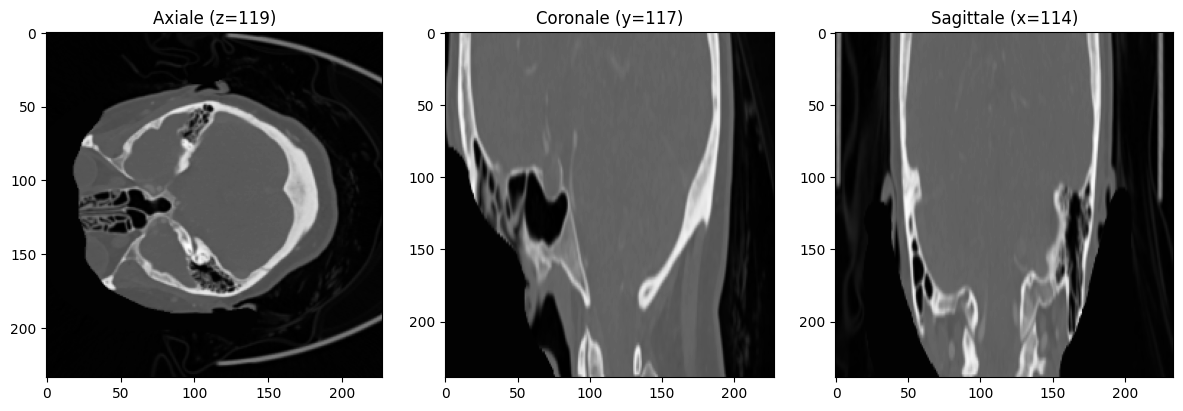

In [39]:
volume=preprocessing(patient_path)
show_middle_slices(volume)

In [40]:
bright_voxels = np.argwhere(volume == volume.max())

In [41]:
volume.shape

(228, 234, 239)

In [42]:
x,y,z=bright_voxels[0]

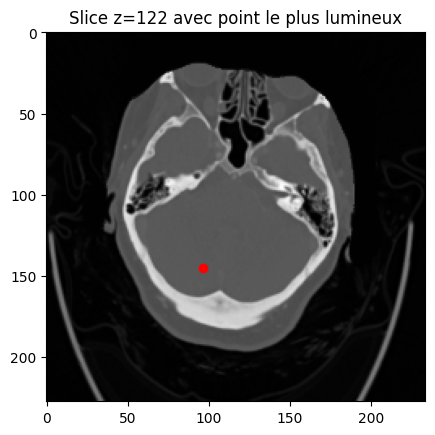

In [43]:
x,y,z = bright_voxels[0]  # ton point max

# slice axiale (XY plane) à la profondeur z
plt.imshow(volume[:, :, z], cmap='gray')
plt.scatter(x, y, color='red')  # le point choisi
plt.title(f"Slice z={z} avec point le plus lumineux")
plt.show()

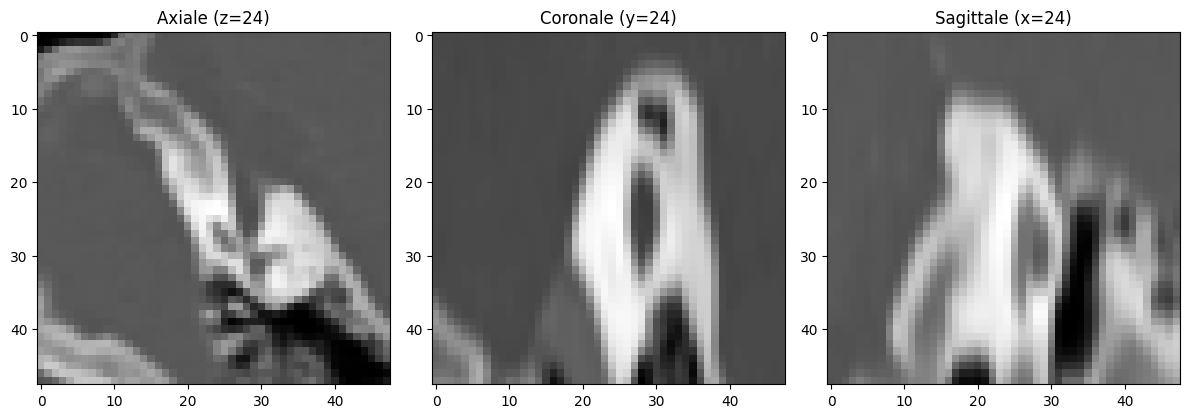

In [44]:
cube=crop_cube(volume, np.array([x,y,z]), size=48)
show_middle_slices(cube)

# **Autre exemple**

df[944]
df_train_neg[93]
df_train[93]

* NumSlices : 180
* image.shape : (1008, 1008)
* volume.shape : (231, 189, 360) #(z,y,x)
* Modality : MRI T1post

In [45]:
df_train_neg[df_train_neg['Modality']=='MRI T1post']

,SeriesInstanceUID,PatientAge,PatientSex,Modality,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present
93,1.2.826.0.1.3680043.8.498.10256018119694768427...,19,Female,MRI T1post,0,0,0,0,0,0,0,0,0,0,0,0,0,0
125,1.2.826.0.1.3680043.8.498.10332445922333724094...,63,Female,MRI T1post,0,0,0,0,0,0,0,0,0,0,0,0,0,0
128,1.2.826.0.1.3680043.8.498.10338035746158737411...,76,Female,MRI T1post,0,0,0,0,0,0,0,0,0,0,0,0,0,0
146,1.2.826.0.1.3680043.8.498.10401423302257944813...,56,Male,MRI T1post,0,0,0,0,0,0,0,0,0,0,0,0,0,0
158,1.2.826.0.1.3680043.8.498.10426108253890352854...,35,Male,MRI T1post,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4203,1.2.826.0.1.3680043.8.498.96418414580101152707...,21,Female,MRI T1post,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4209,1.2.826.0.1.3680043.8.498.96574268049022070824...,21,Female,MRI T1post,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4211,1.2.826.0.1.3680043.8.498.96589243215078672247...,79,Female,MRI T1post,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4282,1.2.826.0.1.3680043.8.498.98405412367001982891...,65,Female,MRI T1post,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [46]:
df_train[df_train['SeriesInstanceUID']==df_train_neg['SeriesInstanceUID'][93]]

,SeriesInstanceUID,PatientAge,PatientSex,Modality,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present
93,1.2.826.0.1.3680043.8.498.10256018119694768427...,19,Female,MRI T1post,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [47]:
df[df['SeriesInstanceUID']==df_train_neg['SeriesInstanceUID'][93]]

,SeriesInstanceUID,PatientPath,NumSlices,Aneurysm Present
944,1.2.826.0.1.3680043.8.498.10256018119694768427...,/kaggle/input/rsna-intracranial-aneurysm-detec...,180,0


In [48]:
series_path='/kaggle/input/rsna-intracranial-aneurysm-detection/series'
#lien du patient (série)
patient_path=os.path.join(series_path,
                                  f"{df_train_neg['SeriesInstanceUID'][93]}")
#lien d'une coupe
# Lister les fichiers dans ce dossier
all_files = os.listdir(patient_path)
# Filtrer éventuellement pour ne garder que les fichiers DICOM (.dcm)
dicom_files = [f for f in all_files if f.endswith(".dcm")]
# Prendre le premier fichier pour exemple
exemple_path = os.path.join(patient_path, dicom_files[0])

ds = pydicom.dcmread(exemple_path)

# accéder aux pixels
image = ds.pixel_array
image.shape

(1008, 1008)

In [49]:
iop=ds.ImageOrientationPatient
row = np.array(iop[0:3], dtype=float)
col = np.array(iop[3:6], dtype=float)
normal = np.cross(row, col)

axis = np.argmax(np.abs(normal))  # axe dominant

if axis == 0: 
  print("Sagittal")
elif axis == 1:
    print("Coronal")
elif axis == 2:
    print("Axial")
else:
    print("Inconnu")

Axial


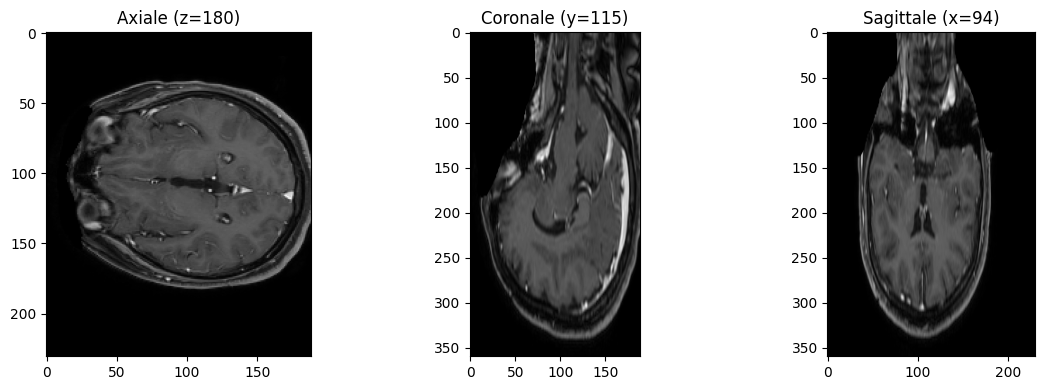

In [50]:
volume=preprocessing(patient_path)
show_middle_slices(volume)

In [51]:
volume.shape

(189, 231, 360)

In [52]:
bright_voxels = np.argwhere(volume == volume.max())
bright_voxels[0]
x,y,z= bright_voxels[0]

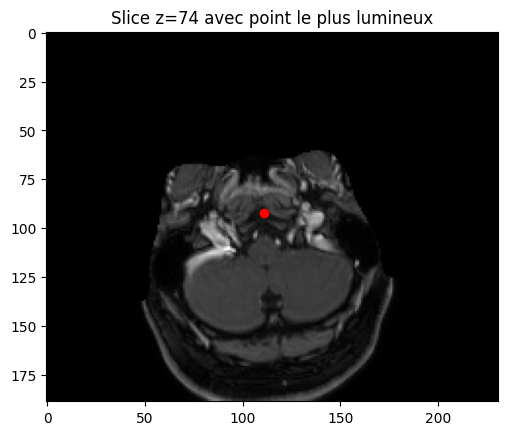

In [53]:
x,y,z = bright_voxels[0]  # ton point max

# slice axiale (XY plane) à la profondeur z
plt.imshow(volume[:, :, z], cmap='gray')
plt.scatter(x, y, color='red')  # le point choisi
plt.title(f"Slice z={z} avec point le plus lumineux")
plt.show()

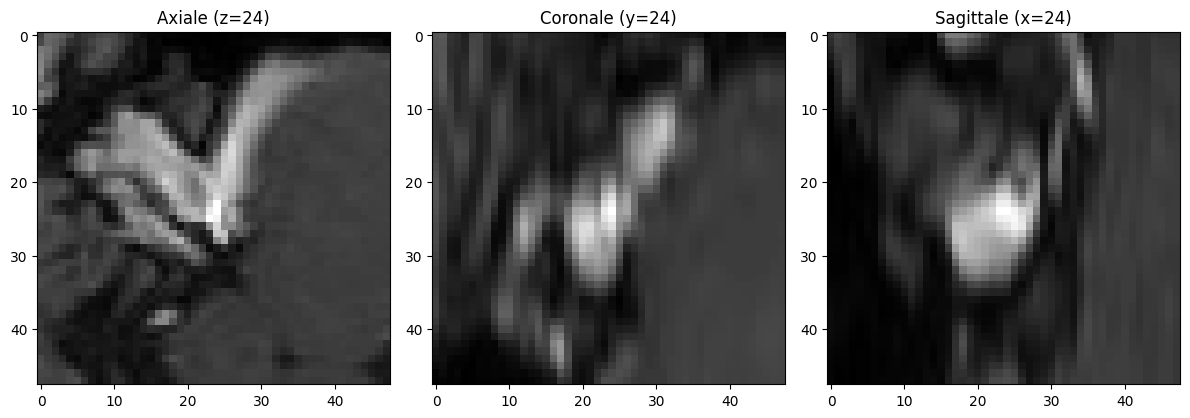

In [54]:
cube=crop_cube(volume, np.array([x,y,z]), size=48)
show_middle_slices(cube)

# **Généralisation**

In [55]:
df_train_neg['Modality'].value_counts()

Modality
CTA           834
MRI T2        725
MRA           697
MRI T1post    228
Name: count, dtype: int64

In [56]:
df_intersect = df_train_neg[df_train_neg['SeriesInstanceUID'].isin(df['SeriesInstanceUID'])]

In [57]:
df_intersect['Modality'].value_counts()

Modality
MRA           616
CTA           421
MRI T2        376
MRI T1post    187
Name: count, dtype: int64

In [58]:
df_intersect_MRI_T1post = df_intersect[df_intersect['Modality']=='MRI T1post']
df_intersect_MRI_T2 = df_intersect[df_intersect['Modality']=='MRI T2']
df_intersect_MRA = df_intersect[df_intersect['Modality']=='MRA']
df_intersect_CTA = df_intersect[df_intersect['Modality']=='CTA']

# **Généralisation**

# **Dataset négatif MRI T1post**

* df_intersect_MRI_T1post.shape = (187, 18)
* Nombre de cubes positifs : 90
* Nombre de cubes centrés négatifs : 187

In [59]:
df_intersect_MRI_T1post.shape

(187, 18)

In [60]:
pos=np.load("/kaggle/input/cubes-positifs/cubes_MRI_T1post.npy")

In [61]:
pos.shape

(90, 48, 48, 48)

cubes_neg=dataset_cubes_neg(df_intersect_MRI_T1post)
cubes_filtered = [c for c in cubes_neg if c.shape == (48,48,48)] 
print(len(cubes_filtered), "cubes restants") 
cubes_array = np.array(cubes_filtered) 
print(cubes_array.shape) # (N,48,48,48) 
np.save("cubes_neg_test.npy", cubes_array)

In [62]:
#cubes_neg_2=dataset_cubes_neg(df_intersect_MRI_T1post.iloc[:3])

cubes_neg_2=dataset_cubes_neg(df_intersect_MRI_T1post)
cubes_filtered = [c for c in cubes_neg_2 if c.shape == (48,48,48)]
print(len(cubes_filtered), "cubes restants") 
cubes_array = np.array(cubes_filtered) 
print(cubes_array.shape) # (N,48,48,48) 

In [63]:
df_pos_test=np.load("/kaggle/input/cubes-positifs/cubes_MRI_T1post.npy")

In [64]:
df_pos_test.shape

(90, 48, 48, 48)

In [ ]:
df_neg_test=np.load("")